In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sig_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_bas_data_nor_b25_roi_t1_mask_t1_nat_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_t1_0_42_n_nat_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(878801, 672)
(878801, 3)
validation
(151459, 672)
(151459, 3)
test
(112754, 672)
(112754, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 672)]             0         


 dense (Dense)               (None, 2048)              1378304   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 4165891 (15.89 MB)


Trainable params: 4165891 (15.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:20 - loss: 1.1523 - STD: 0.1646 - MAE: 0.4300

2/9 [=====>........................] - ETA: 2s - loss: 1.1312 - STD: 0.1533 - MAE: 0.4289  

3/9 [=========>....................] - ETA: 2s - loss: 1.1308 - STD: 0.1328 - MAE: 0.4329

4/9 [============>.................] - ETA: 1s - loss: 1.1269 - STD: 0.1150 - MAE: 0.4356

5/9 [===============>..............] - ETA: 1s - loss: 1.1183 - STD: 0.1004 - MAE: 0.4364

6/9 [===================>..........] - ETA: 1s - loss: 1.1110 - STD: 0.0956 - MAE: 0.4360

7/9 [======================>.......] - ETA: 0s - loss: 1.1071 - STD: 0.0967 - MAE: 0.4352

8/9 [=========================>....] - ETA: 1s - loss: 1.1056 - STD: 0.0996 - MAE: 0.4342

9/9 [==============================] - ETA: 0s - loss: 1.1045 - STD: 0.1021 - MAE: 0.4335

9/9 [==============================] - 23s 2s/step - loss: 1.1045 - STD: 0.1021 - MAE: 0.4335 - val_loss: 1.0864 - val_STD: 0.1136 - val_MAE: 0.4282


Epoch 2/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0886 - STD: 0.1137 - MAE: 0.4286

2/9 [=====>........................] - ETA: 2s - loss: 1.0831 - STD: 0.1056 - MAE: 0.4294

3/9 [=========>....................] - ETA: 2s - loss: 1.0794 - STD: 0.0963 - MAE: 0.4305

4/9 [============>.................] - ETA: 1s - loss: 1.0777 - STD: 0.0871 - MAE: 0.4316

5/9 [===============>..............] - ETA: 1s - loss: 1.0774 - STD: 0.0795 - MAE: 0.4327

6/9 [===================>..........] - ETA: 1s - loss: 1.0775 - STD: 0.0746 - MAE: 0.4335

7/9 [======================>.......] - ETA: 0s - loss: 1.0775 - STD: 0.0720 - MAE: 0.4339

8/9 [=========================>....] - ETA: 0s - loss: 1.0770 - STD: 0.0711 - MAE: 0.4340

9/9 [==============================] - ETA: 0s - loss: 1.0759 - STD: 0.0712 - MAE: 0.4338

9/9 [==============================] - 4s 456ms/step - loss: 1.0759 - STD: 0.0712 - MAE: 0.4338 - val_loss: 1.0629 - val_STD: 0.0743 - val_MAE: 0.4309


Epoch 3/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0620 - STD: 0.0759 - MAE: 0.4304

2/9 [=====>........................] - ETA: 2s - loss: 1.0594 - STD: 0.0772 - MAE: 0.4295

3/9 [=========>....................] - ETA: 2s - loss: 1.0574 - STD: 0.0789 - MAE: 0.4287

4/9 [============>.................] - ETA: 1s - loss: 1.0550 - STD: 0.0808 - MAE: 0.4278

5/9 [===============>..............] - ETA: 1s - loss: 1.0517 - STD: 0.0829 - MAE: 0.4265

6/9 [===================>..........] - ETA: 1s - loss: 1.0469 - STD: 0.0849 - MAE: 0.4249

7/9 [======================>.......] - ETA: 0s - loss: 1.0408 - STD: 0.0867 - MAE: 0.4230

8/9 [=========================>....] - ETA: 0s - loss: 1.0344 - STD: 0.0879 - MAE: 0.4208

9/9 [==============================] - ETA: 0s - loss: 1.0243 - STD: 0.0889 - MAE: 0.4184

9/9 [==============================] - 4s 461ms/step - loss: 1.0243 - STD: 0.0889 - MAE: 0.4184 - val_loss: 0.9265 - val_STD: 0.0983 - val_MAE: 0.3944


Epoch 4/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.9120 - STD: 0.1098 - MAE: 0.3880

2/9 [=====>........................] - ETA: 2s - loss: 0.8931 - STD: 0.1224 - MAE: 0.3806

3/9 [=========>....................] - ETA: 2s - loss: 0.8738 - STD: 0.1332 - MAE: 0.3736

4/9 [============>.................] - ETA: 1s - loss: 0.8557 - STD: 0.1454 - MAE: 0.3662

5/9 [===============>..............] - ETA: 1s - loss: 0.8397 - STD: 0.1596 - MAE: 0.3581

6/9 [===================>..........] - ETA: 1s - loss: 0.8271 - STD: 0.1712 - MAE: 0.3515

7/9 [======================>.......] - ETA: 0s - loss: 0.8164 - STD: 0.1853 - MAE: 0.3437

8/9 [=========================>....] - ETA: 0s - loss: 0.8074 - STD: 0.1968 - MAE: 0.3372

9/9 [==============================] - ETA: 0s - loss: 0.8024 - STD: 0.2062 - MAE: 0.3320

9/9 [==============================] - 4s 456ms/step - loss: 0.8024 - STD: 0.2062 - MAE: 0.3320 - val_loss: 0.7814 - val_STD: 0.2858 - val_MAE: 0.2927


Epoch 5/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.7460 - STD: 0.3022 - MAE: 0.2772

2/9 [=====>........................] - ETA: 2s - loss: 0.7426 - STD: 0.3014 - MAE: 0.2770

3/9 [=========>....................] - ETA: 2s - loss: 0.7415 - STD: 0.2981 - MAE: 0.2785

4/9 [============>.................] - ETA: 1s - loss: 0.7369 - STD: 0.2981 - MAE: 0.2777

5/9 [===============>..............] - ETA: 1s - loss: 0.7321 - STD: 0.2974 - MAE: 0.2773

6/9 [===================>..........] - ETA: 1s - loss: 0.7269 - STD: 0.2941 - MAE: 0.2782

7/9 [======================>.......] - ETA: 0s - loss: 0.7213 - STD: 0.2913 - MAE: 0.2788

8/9 [=========================>....] - ETA: 0s - loss: 0.7168 - STD: 0.2887 - MAE: 0.2793

9/9 [==============================] - ETA: 0s - loss: 0.7128 - STD: 0.2851 - MAE: 0.2803

9/9 [==============================] - 4s 458ms/step - loss: 0.7128 - STD: 0.2851 - MAE: 0.2803 - val_loss: 0.6874 - val_STD: 0.2492 - val_MAE: 0.2936


Epoch 6/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.6761 - STD: 0.2605 - MAE: 0.2853

2/9 [=====>........................] - ETA: 2s - loss: 0.6728 - STD: 0.2688 - MAE: 0.2802

3/9 [=========>....................] - ETA: 2s - loss: 0.6710 - STD: 0.2747 - MAE: 0.2767

4/9 [============>.................] - ETA: 1s - loss: 0.6690 - STD: 0.2797 - MAE: 0.2738

5/9 [===============>..............] - ETA: 1s - loss: 0.6662 - STD: 0.2847 - MAE: 0.2706

6/9 [===================>..........] - ETA: 1s - loss: 0.6632 - STD: 0.2876 - MAE: 0.2685

7/9 [======================>.......] - ETA: 0s - loss: 0.6593 - STD: 0.2885 - MAE: 0.2672

8/9 [=========================>....] - ETA: 0s - loss: 0.6566 - STD: 0.2891 - MAE: 0.2663

9/9 [==============================] - ETA: 0s - loss: 0.6540 - STD: 0.2893 - MAE: 0.2656

9/9 [==============================] - 5s 464ms/step - loss: 0.6540 - STD: 0.2893 - MAE: 0.2656 - val_loss: 0.6238 - val_STD: 0.2868 - val_MAE: 0.2613


Epoch 7/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6268 - STD: 0.2933 - MAE: 0.2574

2/9 [=====>........................] - ETA: 2s - loss: 0.6263 - STD: 0.3000 - MAE: 0.2534

3/9 [=========>....................] - ETA: 2s - loss: 0.6244 - STD: 0.3037 - MAE: 0.2510

4/9 [============>.................] - ETA: 1s - loss: 0.6221 - STD: 0.3071 - MAE: 0.2486

5/9 [===============>..............] - ETA: 1s - loss: 0.6197 - STD: 0.3098 - MAE: 0.2465

6/9 [===================>..........] - ETA: 1s - loss: 0.6176 - STD: 0.3094 - MAE: 0.2465

7/9 [======================>.......] - ETA: 0s - loss: 0.6147 - STD: 0.3097 - MAE: 0.2457

8/9 [=========================>....] - ETA: 0s - loss: 0.6127 - STD: 0.3087 - MAE: 0.2458

9/9 [==============================] - ETA: 0s - loss: 0.6096 - STD: 0.3086 - MAE: 0.2453

9/9 [==============================] - 5s 477ms/step - loss: 0.6096 - STD: 0.3086 - MAE: 0.2453 - val_loss: 0.5575 - val_STD: 0.3142 - val_MAE: 0.2326


Epoch 8/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5909 - STD: 0.3219 - MAE: 0.2338

2/9 [=====>........................] - ETA: 2s - loss: 0.5904 - STD: 0.3190 - MAE: 0.2359

3/9 [=========>....................] - ETA: 2s - loss: 0.5873 - STD: 0.3224 - MAE: 0.2329

4/9 [============>.................] - ETA: 1s - loss: 0.5840 - STD: 0.3205 - MAE: 0.2334

5/9 [===============>..............] - ETA: 1s - loss: 0.5803 - STD: 0.3193 - MAE: 0.2334

6/9 [===================>..........] - ETA: 1s - loss: 0.5789 - STD: 0.3203 - MAE: 0.2324

7/9 [======================>.......] - ETA: 0s - loss: 0.5776 - STD: 0.3203 - MAE: 0.2322

8/9 [=========================>....] - ETA: 0s - loss: 0.5760 - STD: 0.3221 - MAE: 0.2306

9/9 [==============================] - ETA: 0s - loss: 0.5733 - STD: 0.3232 - MAE: 0.2293

9/9 [==============================] - 4s 431ms/step - loss: 0.5733 - STD: 0.3232 - MAE: 0.2293 - val_loss: 0.5408 - val_STD: 0.3208 - val_MAE: 0.2260


Epoch 9/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5456 - STD: 0.3281 - MAE: 0.2207

2/9 [=====>........................] - ETA: 2s - loss: 0.5494 - STD: 0.3308 - MAE: 0.2193

3/9 [=========>....................] - ETA: 2s - loss: 0.5490 - STD: 0.3300 - MAE: 0.2200

4/9 [============>.................] - ETA: 1s - loss: 0.5471 - STD: 0.3314 - MAE: 0.2185

5/9 [===============>..............] - ETA: 1s - loss: 0.5442 - STD: 0.3326 - MAE: 0.2171

6/9 [===================>..........] - ETA: 1s - loss: 0.5427 - STD: 0.3331 - MAE: 0.2166

7/9 [======================>.......] - ETA: 0s - loss: 0.5422 - STD: 0.3339 - MAE: 0.2158

8/9 [=========================>....] - ETA: 0s - loss: 0.5414 - STD: 0.3340 - MAE: 0.2156

9/9 [==============================] - ETA: 0s - loss: 0.5405 - STD: 0.3346 - MAE: 0.2150

9/9 [==============================] - 4s 463ms/step - loss: 0.5405 - STD: 0.3346 - MAE: 0.2150 - val_loss: 0.4970 - val_STD: 0.3315 - val_MAE: 0.2101


Epoch 10/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5197 - STD: 0.3393 - MAE: 0.2076

2/9 [=====>........................] - ETA: 3s - loss: 0.5201 - STD: 0.3407 - MAE: 0.2067

3/9 [=========>....................] - ETA: 2s - loss: 0.5197 - STD: 0.3421 - MAE: 0.2055

4/9 [============>.................] - ETA: 1s - loss: 0.5202 - STD: 0.3423 - MAE: 0.2055

5/9 [===============>..............] - ETA: 1s - loss: 0.5199 - STD: 0.3431 - MAE: 0.2048

6/9 [===================>..........] - ETA: 1s - loss: 0.5188 - STD: 0.3436 - MAE: 0.2043

7/9 [======================>.......] - ETA: 0s - loss: 0.5165 - STD: 0.3443 - MAE: 0.2033

8/9 [=========================>....] - ETA: 0s - loss: 0.5154 - STD: 0.3450 - MAE: 0.2026

9/9 [==============================] - ETA: 0s - loss: 0.5139 - STD: 0.3454 - MAE: 0.2019

9/9 [==============================] - 4s 465ms/step - loss: 0.5139 - STD: 0.3454 - MAE: 0.2019 - val_loss: 0.4569 - val_STD: 0.3425 - val_MAE: 0.1936


Epoch 11/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5023 - STD: 0.3523 - MAE: 0.1942

2/9 [=====>........................] - ETA: 3s - loss: 0.5018 - STD: 0.3520 - MAE: 0.1945

3/9 [=========>....................] - ETA: 2s - loss: 0.5012 - STD: 0.3520 - MAE: 0.1942

4/9 [============>.................] - ETA: 2s - loss: 0.4995 - STD: 0.3523 - MAE: 0.1937

5/9 [===============>..............] - ETA: 1s - loss: 0.4979 - STD: 0.3524 - MAE: 0.1933

6/9 [===================>..........] - ETA: 1s - loss: 0.4972 - STD: 0.3528 - MAE: 0.1929

7/9 [======================>.......] - ETA: 0s - loss: 0.4965 - STD: 0.3530 - MAE: 0.1926

8/9 [=========================>....] - ETA: 0s - loss: 0.4956 - STD: 0.3532 - MAE: 0.1922

9/9 [==============================] - ETA: 0s - loss: 0.4946 - STD: 0.3534 - MAE: 0.1918

9/9 [==============================] - 4s 464ms/step - loss: 0.4946 - STD: 0.3534 - MAE: 0.1918 - val_loss: 0.4503 - val_STD: 0.3493 - val_MAE: 0.1880


Epoch 12/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4781 - STD: 0.3568 - MAE: 0.1858

2/9 [=====>........................] - ETA: 2s - loss: 0.4798 - STD: 0.3573 - MAE: 0.1857

3/9 [=========>....................] - ETA: 2s - loss: 0.4793 - STD: 0.3574 - MAE: 0.1856

4/9 [============>.................] - ETA: 1s - loss: 0.4793 - STD: 0.3578 - MAE: 0.1852

5/9 [===============>..............] - ETA: 1s - loss: 0.4785 - STD: 0.3582 - MAE: 0.1848

6/9 [===================>..........] - ETA: 1s - loss: 0.4765 - STD: 0.3586 - MAE: 0.1840

7/9 [======================>.......] - ETA: 0s - loss: 0.4751 - STD: 0.3591 - MAE: 0.1833

8/9 [=========================>....] - ETA: 0s - loss: 0.4738 - STD: 0.3596 - MAE: 0.1827

9/9 [==============================] - ETA: 0s - loss: 0.4733 - STD: 0.3600 - MAE: 0.1822

9/9 [==============================] - 4s 455ms/step - loss: 0.4733 - STD: 0.3600 - MAE: 0.1822 - val_loss: 0.4843 - val_STD: 0.3572 - val_MAE: 0.1902


Epoch 13/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4705 - STD: 0.3630 - MAE: 0.1792

2/9 [=====>........................] - ETA: 2s - loss: 0.4725 - STD: 0.3626 - MAE: 0.1801

3/9 [=========>....................] - ETA: 2s - loss: 0.4695 - STD: 0.3631 - MAE: 0.1791

4/9 [============>.................] - ETA: 1s - loss: 0.4653 - STD: 0.3641 - MAE: 0.1775

5/9 [===============>..............] - ETA: 1s - loss: 0.4629 - STD: 0.3648 - MAE: 0.1764

6/9 [===================>..........] - ETA: 1s - loss: 0.4624 - STD: 0.3649 - MAE: 0.1761

7/9 [======================>.......] - ETA: 0s - loss: 0.4621 - STD: 0.3648 - MAE: 0.1761

8/9 [=========================>....] - ETA: 0s - loss: 0.4612 - STD: 0.3650 - MAE: 0.1759

9/9 [==============================] - ETA: 0s - loss: 0.4596 - STD: 0.3652 - MAE: 0.1753

9/9 [==============================] - 4s 462ms/step - loss: 0.4596 - STD: 0.3652 - MAE: 0.1753 - val_loss: 0.4092 - val_STD: 0.3633 - val_MAE: 0.1688


Epoch 14/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4467 - STD: 0.3668 - MAE: 0.1710

2/9 [=====>........................] - ETA: 2s - loss: 0.4472 - STD: 0.3670 - MAE: 0.1710

3/9 [=========>....................] - ETA: 2s - loss: 0.4485 - STD: 0.3668 - MAE: 0.1714

4/9 [============>.................] - ETA: 1s - loss: 0.4450 - STD: 0.3673 - MAE: 0.1702

5/9 [===============>..............] - ETA: 1s - loss: 0.4426 - STD: 0.3678 - MAE: 0.1692

6/9 [===================>..........] - ETA: 1s - loss: 0.4409 - STD: 0.3679 - MAE: 0.1689

7/9 [======================>.......] - ETA: 0s - loss: 0.4396 - STD: 0.3682 - MAE: 0.1684

8/9 [=========================>....] - ETA: 0s - loss: 0.4383 - STD: 0.3687 - MAE: 0.1678

9/9 [==============================] - ETA: 0s - loss: 0.4368 - STD: 0.3690 - MAE: 0.1672

9/9 [==============================] - 4s 434ms/step - loss: 0.4368 - STD: 0.3690 - MAE: 0.1672 - val_loss: 0.4106 - val_STD: 0.3686 - val_MAE: 0.1656


Epoch 15/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4182 - STD: 0.3724 - MAE: 0.1607

2/9 [=====>........................] - ETA: 2s - loss: 0.4176 - STD: 0.3728 - MAE: 0.1603

3/9 [=========>....................] - ETA: 2s - loss: 0.4167 - STD: 0.3725 - MAE: 0.1602

4/9 [============>.................] - ETA: 1s - loss: 0.4154 - STD: 0.3731 - MAE: 0.1596

5/9 [===============>..............] - ETA: 1s - loss: 0.4138 - STD: 0.3732 - MAE: 0.1592

6/9 [===================>..........] - ETA: 1s - loss: 0.4124 - STD: 0.3734 - MAE: 0.1588

7/9 [======================>.......] - ETA: 0s - loss: 0.4112 - STD: 0.3737 - MAE: 0.1583

8/9 [=========================>....] - ETA: 0s - loss: 0.4091 - STD: 0.3739 - MAE: 0.1578

9/9 [==============================] - ETA: 0s - loss: 0.4073 - STD: 0.3744 - MAE: 0.1571

9/9 [==============================] - 4s 467ms/step - loss: 0.4073 - STD: 0.3744 - MAE: 0.1571 - val_loss: 0.4196 - val_STD: 0.3745 - val_MAE: 0.1644


Epoch 16/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3953 - STD: 0.3761 - MAE: 0.1537

2/9 [=====>........................] - ETA: 2s - loss: 0.3961 - STD: 0.3804 - MAE: 0.1508

3/9 [=========>....................] - ETA: 2s - loss: 0.3954 - STD: 0.3793 - MAE: 0.1517

4/9 [============>.................] - ETA: 1s - loss: 0.3931 - STD: 0.3806 - MAE: 0.1502

5/9 [===============>..............] - ETA: 1s - loss: 0.3918 - STD: 0.3810 - MAE: 0.1496

6/9 [===================>..........] - ETA: 1s - loss: 0.3909 - STD: 0.3813 - MAE: 0.1492

7/9 [======================>.......] - ETA: 0s - loss: 0.3901 - STD: 0.3818 - MAE: 0.1486

8/9 [=========================>....] - ETA: 0s - loss: 0.3883 - STD: 0.3824 - MAE: 0.1478

9/9 [==============================] - ETA: 0s - loss: 0.3880 - STD: 0.3825 - MAE: 0.1478

9/9 [==============================] - 4s 455ms/step - loss: 0.3880 - STD: 0.3825 - MAE: 0.1478 - val_loss: 0.4075 - val_STD: 0.3870 - val_MAE: 0.1498


Epoch 17/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4018 - STD: 0.3936 - MAE: 0.1425

2/9 [=====>........................] - ETA: 2s - loss: 0.3924 - STD: 0.3891 - MAE: 0.1442

3/9 [=========>....................] - ETA: 2s - loss: 0.3847 - STD: 0.3886 - MAE: 0.1428

4/9 [============>.................] - ETA: 1s - loss: 0.3804 - STD: 0.3897 - MAE: 0.1411

5/9 [===============>..............] - ETA: 1s - loss: 0.3790 - STD: 0.3891 - MAE: 0.1413

6/9 [===================>..........] - ETA: 1s - loss: 0.3772 - STD: 0.3892 - MAE: 0.1408

7/9 [======================>.......] - ETA: 0s - loss: 0.3746 - STD: 0.3894 - MAE: 0.1401

8/9 [=========================>....] - ETA: 0s - loss: 0.3722 - STD: 0.3892 - MAE: 0.1398

9/9 [==============================] - ETA: 0s - loss: 0.3716 - STD: 0.3891 - MAE: 0.1396

9/9 [==============================] - 4s 448ms/step - loss: 0.3716 - STD: 0.3891 - MAE: 0.1396 - val_loss: 0.3541 - val_STD: 0.3899 - val_MAE: 0.1385


Epoch 18/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3627 - STD: 0.3885 - MAE: 0.1384

2/9 [=====>........................] - ETA: 2s - loss: 0.3546 - STD: 0.3893 - MAE: 0.1361

3/9 [=========>....................] - ETA: 1s - loss: 0.3532 - STD: 0.3893 - MAE: 0.1356

4/9 [============>.................] - ETA: 1s - loss: 0.3543 - STD: 0.3896 - MAE: 0.1357

5/9 [===============>..............] - ETA: 1s - loss: 0.3535 - STD: 0.3901 - MAE: 0.1351

6/9 [===================>..........] - ETA: 1s - loss: 0.3523 - STD: 0.3903 - MAE: 0.1348

7/9 [======================>.......] - ETA: 0s - loss: 0.3511 - STD: 0.3909 - MAE: 0.1341

8/9 [=========================>....] - ETA: 0s - loss: 0.3493 - STD: 0.3912 - MAE: 0.1335

9/9 [==============================] - ETA: 0s - loss: 0.3477 - STD: 0.3914 - MAE: 0.1330

9/9 [==============================] - 4s 444ms/step - loss: 0.3477 - STD: 0.3914 - MAE: 0.1330 - val_loss: 0.3387 - val_STD: 0.3952 - val_MAE: 0.1301


Epoch 19/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3374 - STD: 0.3962 - MAE: 0.1272

2/9 [=====>........................] - ETA: 2s - loss: 0.3349 - STD: 0.3954 - MAE: 0.1274

3/9 [=========>....................] - ETA: 2s - loss: 0.3361 - STD: 0.3957 - MAE: 0.1274

4/9 [============>.................] - ETA: 1s - loss: 0.3395 - STD: 0.3953 - MAE: 0.1285

5/9 [===============>..............] - ETA: 1s - loss: 0.3487 - STD: 0.3962 - MAE: 0.1294

6/9 [===================>..........] - ETA: 1s - loss: 0.3599 - STD: 0.3957 - MAE: 0.1325

7/9 [======================>.......] - ETA: 0s - loss: 0.3639 - STD: 0.3970 - MAE: 0.1322

8/9 [=========================>....] - ETA: 0s - loss: 0.3587 - STD: 0.3974 - MAE: 0.1308

9/9 [==============================] - ETA: 0s - loss: 0.3601 - STD: 0.3973 - MAE: 0.1313

9/9 [==============================] - 4s 430ms/step - loss: 0.3601 - STD: 0.3973 - MAE: 0.1313 - val_loss: 0.3635 - val_STD: 0.4027 - val_MAE: 0.1280


Epoch 20/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3600 - STD: 0.4050 - MAE: 0.1250

2/9 [=====>........................] - ETA: 2s - loss: 0.3431 - STD: 0.4042 - MAE: 0.1223

3/9 [=========>....................] - ETA: 2s - loss: 0.3516 - STD: 0.4014 - MAE: 0.1264

4/9 [============>.................] - ETA: 1s - loss: 0.3456 - STD: 0.4015 - MAE: 0.1251

5/9 [===============>..............] - ETA: 1s - loss: 0.3467 - STD: 0.4022 - MAE: 0.1247

6/9 [===================>..........] - ETA: 1s - loss: 0.3450 - STD: 0.4013 - MAE: 0.1250

7/9 [======================>.......] - ETA: 0s - loss: 0.3435 - STD: 0.4005 - MAE: 0.1254

8/9 [=========================>....] - ETA: 0s - loss: 0.3429 - STD: 0.4007 - MAE: 0.1251

9/9 [==============================] - ETA: 0s - loss: 0.3412 - STD: 0.4005 - MAE: 0.1248

9/9 [==============================] - 4s 433ms/step - loss: 0.3412 - STD: 0.4005 - MAE: 0.1248 - val_loss: 0.3985 - val_STD: 0.3940 - val_MAE: 0.1463


Epoch 21/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3445 - STD: 0.3933 - MAE: 0.1315

2/9 [=====>........................] - ETA: 2s - loss: 0.3310 - STD: 0.3954 - MAE: 0.1269

3/9 [=========>....................] - ETA: 2s - loss: 0.3313 - STD: 0.3970 - MAE: 0.1257

4/9 [============>.................] - ETA: 1s - loss: 0.3294 - STD: 0.3965 - MAE: 0.1257

5/9 [===============>..............] - ETA: 1s - loss: 0.3289 - STD: 0.3961 - MAE: 0.1259

6/9 [===================>..........] - ETA: 1s - loss: 0.3281 - STD: 0.3967 - MAE: 0.1252

7/9 [======================>.......] - ETA: 0s - loss: 0.3266 - STD: 0.3971 - MAE: 0.1246

8/9 [=========================>....] - ETA: 0s - loss: 0.3271 - STD: 0.3970 - MAE: 0.1248

9/9 [==============================] - ETA: 0s - loss: 0.3257 - STD: 0.3973 - MAE: 0.1243

9/9 [==============================] - 4s 426ms/step - loss: 0.3257 - STD: 0.3973 - MAE: 0.1243 - val_loss: 0.3306 - val_STD: 0.4007 - val_MAE: 0.1234


Epoch 22/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3227 - STD: 0.4030 - MAE: 0.1191

2/9 [=====>........................] - ETA: 2s - loss: 0.3180 - STD: 0.4016 - MAE: 0.1194

3/9 [=========>....................] - ETA: 1s - loss: 0.3178 - STD: 0.4011 - MAE: 0.1197

4/9 [============>.................] - ETA: 1s - loss: 0.3181 - STD: 0.4018 - MAE: 0.1192

5/9 [===============>..............] - ETA: 1s - loss: 0.3167 - STD: 0.4019 - MAE: 0.1188

6/9 [===================>..........] - ETA: 1s - loss: 0.3166 - STD: 0.4017 - MAE: 0.1190

7/9 [======================>.......] - ETA: 0s - loss: 0.3153 - STD: 0.4020 - MAE: 0.1185

8/9 [=========================>....] - ETA: 0s - loss: 0.3146 - STD: 0.4021 - MAE: 0.1182

9/9 [==============================] - ETA: 0s - loss: 0.3145 - STD: 0.4020 - MAE: 0.1183

9/9 [==============================] - 4s 437ms/step - loss: 0.3145 - STD: 0.4020 - MAE: 0.1183 - val_loss: 0.3282 - val_STD: 0.4023 - val_MAE: 0.1227


Epoch 23/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3064 - STD: 0.4024 - MAE: 0.1162

2/9 [=====>........................] - ETA: 2s - loss: 0.3093 - STD: 0.4031 - MAE: 0.1163

3/9 [=========>....................] - ETA: 2s - loss: 0.3078 - STD: 0.4031 - MAE: 0.1161

4/9 [============>.................] - ETA: 1s - loss: 0.3069 - STD: 0.4031 - MAE: 0.1159

5/9 [===============>..............] - ETA: 1s - loss: 0.3070 - STD: 0.4035 - MAE: 0.1156

6/9 [===================>..........] - ETA: 1s - loss: 0.3062 - STD: 0.4037 - MAE: 0.1153

7/9 [======================>.......] - ETA: 0s - loss: 0.3056 - STD: 0.4038 - MAE: 0.1150

8/9 [=========================>....] - ETA: 0s - loss: 0.3057 - STD: 0.4041 - MAE: 0.1148

9/9 [==============================] - ETA: 0s - loss: 0.3049 - STD: 0.4042 - MAE: 0.1146

9/9 [==============================] - 4s 435ms/step - loss: 0.3049 - STD: 0.4042 - MAE: 0.1146 - val_loss: 0.3352 - val_STD: 0.4042 - val_MAE: 0.1220


Epoch 24/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.2982 - STD: 0.4057 - MAE: 0.1121

2/9 [=====>........................] - ETA: 2s - loss: 0.2984 - STD: 0.4061 - MAE: 0.1119

3/9 [=========>....................] - ETA: 2s - loss: 0.2985 - STD: 0.4059 - MAE: 0.1120

4/9 [============>.................] - ETA: 1s - loss: 0.2985 - STD: 0.4059 - MAE: 0.1121

5/9 [===============>..............] - ETA: 1s - loss: 0.2983 - STD: 0.4060 - MAE: 0.1120

6/9 [===================>..........] - ETA: 1s - loss: 0.2986 - STD: 0.4058 - MAE: 0.1122

7/9 [======================>.......] - ETA: 0s - loss: 0.2985 - STD: 0.4059 - MAE: 0.1121

8/9 [=========================>....] - ETA: 0s - loss: 0.2984 - STD: 0.4058 - MAE: 0.1121

9/9 [==============================] - ETA: 0s - loss: 0.2981 - STD: 0.4059 - MAE: 0.1120

9/9 [==============================] - 4s 429ms/step - loss: 0.2981 - STD: 0.4059 - MAE: 0.1120 - val_loss: 0.3325 - val_STD: 0.4050 - val_MAE: 0.1204


Epoch 25/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.2942 - STD: 0.4065 - MAE: 0.1107

2/9 [=====>........................] - ETA: 1s - loss: 0.2976 - STD: 0.4063 - MAE: 0.1118

3/9 [=========>....................] - ETA: 1s - loss: 0.3002 - STD: 0.4068 - MAE: 0.1118

4/9 [============>.................] - ETA: 1s - loss: 0.3032 - STD: 0.4067 - MAE: 0.1126

5/9 [===============>..............] - ETA: 1s - loss: 0.3069 - STD: 0.4071 - MAE: 0.1129

6/9 [===================>..........] - ETA: 1s - loss: 0.3104 - STD: 0.4071 - MAE: 0.1136

7/9 [======================>.......] - ETA: 0s - loss: 0.3125 - STD: 0.4074 - MAE: 0.1138

8/9 [=========================>....] - ETA: 0s - loss: 0.3118 - STD: 0.4077 - MAE: 0.1135

9/9 [==============================] - ETA: 0s - loss: 0.3100 - STD: 0.4079 - MAE: 0.1129

9/9 [==============================] - 4s 429ms/step - loss: 0.3100 - STD: 0.4079 - MAE: 0.1129 - val_loss: 0.3296 - val_STD: 0.4106 - val_MAE: 0.1149


Epoch 26/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3057 - STD: 0.4121 - MAE: 0.1088

2/9 [=====>........................] - ETA: 2s - loss: 0.3100 - STD: 0.4104 - MAE: 0.1111

3/9 [=========>....................] - ETA: 2s - loss: 0.3082 - STD: 0.4101 - MAE: 0.1110

4/9 [============>.................] - ETA: 1s - loss: 0.3038 - STD: 0.4100 - MAE: 0.1101

5/9 [===============>..............] - ETA: 1s - loss: 0.3039 - STD: 0.4094 - MAE: 0.1107

6/9 [===================>..........] - ETA: 1s - loss: 0.3059 - STD: 0.4094 - MAE: 0.1111

7/9 [======================>.......] - ETA: 0s - loss: 0.3043 - STD: 0.4089 - MAE: 0.1110

8/9 [=========================>....] - ETA: 0s - loss: 0.3020 - STD: 0.4086 - MAE: 0.1108

9/9 [==============================] - ETA: 0s - loss: 0.3018 - STD: 0.4085 - MAE: 0.1109

9/9 [==============================] - 4s 433ms/step - loss: 0.3018 - STD: 0.4085 - MAE: 0.1109 - val_loss: 0.3568 - val_STD: 0.4064 - val_MAE: 0.1264


Epoch 27/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.3017 - STD: 0.4053 - MAE: 0.1137

2/9 [=====>........................] - ETA: 2s - loss: 0.2957 - STD: 0.4065 - MAE: 0.1113

3/9 [=========>....................] - ETA: 2s - loss: 0.2927 - STD: 0.4070 - MAE: 0.1103

4/9 [============>.................] - ETA: 1s - loss: 0.2945 - STD: 0.4069 - MAE: 0.1107

5/9 [===============>..............] - ETA: 1s - loss: 0.2938 - STD: 0.4074 - MAE: 0.1103

6/9 [===================>..........] - ETA: 1s - loss: 0.2925 - STD: 0.4076 - MAE: 0.1098

7/9 [======================>.......] - ETA: 0s - loss: 0.2919 - STD: 0.4078 - MAE: 0.1095

8/9 [=========================>....] - ETA: 0s - loss: 0.2922 - STD: 0.4082 - MAE: 0.1093

9/9 [==============================] - ETA: 0s - loss: 0.2915 - STD: 0.4082 - MAE: 0.1091

9/9 [==============================] - 4s 435ms/step - loss: 0.2915 - STD: 0.4082 - MAE: 0.1091 - val_loss: 0.3109 - val_STD: 0.4099 - val_MAE: 0.1127


Epoch 28/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.2817 - STD: 0.4097 - MAE: 0.1061

2/9 [=====>........................] - ETA: 2s - loss: 0.2844 - STD: 0.4093 - MAE: 0.1069

3/9 [=========>....................] - ETA: 2s - loss: 0.2871 - STD: 0.4091 - MAE: 0.1076

4/9 [============>.................] - ETA: 1s - loss: 0.2862 - STD: 0.4092 - MAE: 0.1073

5/9 [===============>..............] - ETA: 1s - loss: 0.2850 - STD: 0.4093 - MAE: 0.1070

6/9 [===================>..........] - ETA: 1s - loss: 0.2859 - STD: 0.4092 - MAE: 0.1072

7/9 [======================>.......] - ETA: 0s - loss: 0.2869 - STD: 0.4092 - MAE: 0.1074

8/9 [=========================>....] - ETA: 0s - loss: 0.2876 - STD: 0.4092 - MAE: 0.1075

9/9 [==============================] - ETA: 0s - loss: 0.2884 - STD: 0.4091 - MAE: 0.1078

9/9 [==============================] - 4s 432ms/step - loss: 0.2884 - STD: 0.4091 - MAE: 0.1078 - val_loss: 0.2935 - val_STD: 0.4138 - val_MAE: 0.1054


Epoch 29/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2970 - STD: 0.4123 - MAE: 0.1071

2/9 [=====>........................] - ETA: 2s - loss: 0.2936 - STD: 0.4110 - MAE: 0.1075

3/9 [=========>....................] - ETA: 2s - loss: 0.2881 - STD: 0.4113 - MAE: 0.1062

4/9 [============>.................] - ETA: 1s - loss: 0.2872 - STD: 0.4112 - MAE: 0.1061

5/9 [===============>..............] - ETA: 1s - loss: 0.2861 - STD: 0.4109 - MAE: 0.1060

6/9 [===================>..........] - ETA: 1s - loss: 0.2866 - STD: 0.4111 - MAE: 0.1060

7/9 [======================>.......] - ETA: 0s - loss: 0.2864 - STD: 0.4108 - MAE: 0.1062

8/9 [=========================>....] - ETA: 0s - loss: 0.2857 - STD: 0.4109 - MAE: 0.1060

9/9 [==============================] - ETA: 0s - loss: 0.2851 - STD: 0.4108 - MAE: 0.1059

9/9 [==============================] - 4s 440ms/step - loss: 0.2851 - STD: 0.4108 - MAE: 0.1059 - val_loss: 0.3265 - val_STD: 0.4090 - val_MAE: 0.1161


Epoch 30/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.2782 - STD: 0.4100 - MAE: 0.1053

2/9 [=====>........................] - ETA: 2s - loss: 0.2799 - STD: 0.4109 - MAE: 0.1049

3/9 [=========>....................] - ETA: 2s - loss: 0.2816 - STD: 0.4104 - MAE: 0.1057

4/9 [============>.................] - ETA: 1s - loss: 0.2821 - STD: 0.4108 - MAE: 0.1054

5/9 [===============>..............] - ETA: 1s - loss: 0.2812 - STD: 0.4109 - MAE: 0.1051

6/9 [===================>..........] - ETA: 1s - loss: 0.2800 - STD: 0.4111 - MAE: 0.1047

7/9 [======================>.......] - ETA: 0s - loss: 0.2801 - STD: 0.4114 - MAE: 0.1045

8/9 [=========================>....] - ETA: 0s - loss: 0.2802 - STD: 0.4114 - MAE: 0.1045

9/9 [==============================] - ETA: 0s - loss: 0.2811 - STD: 0.4115 - MAE: 0.1046

9/9 [==============================] - 4s 437ms/step - loss: 0.2811 - STD: 0.4115 - MAE: 0.1046 - val_loss: 0.3537 - val_STD: 0.4090 - val_MAE: 0.1211


Epoch 31/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2869 - STD: 0.4112 - MAE: 0.1059

2/9 [=====>........................] - ETA: 1s - loss: 0.2894 - STD: 0.4119 - MAE: 0.1060

3/9 [=========>....................] - ETA: 1s - loss: 0.2888 - STD: 0.4121 - MAE: 0.1057

4/9 [============>.................] - ETA: 1s - loss: 0.2890 - STD: 0.4123 - MAE: 0.1057

5/9 [===============>..............] - ETA: 1s - loss: 0.2895 - STD: 0.4129 - MAE: 0.1053

6/9 [===================>..........] - ETA: 1s - loss: 0.2890 - STD: 0.4128 - MAE: 0.1052

7/9 [======================>.......] - ETA: 0s - loss: 0.2875 - STD: 0.4132 - MAE: 0.1047

8/9 [=========================>....] - ETA: 0s - loss: 0.2857 - STD: 0.4132 - MAE: 0.1043

9/9 [==============================] - ETA: 0s - loss: 0.2843 - STD: 0.4132 - MAE: 0.1040

9/9 [==============================] - 4s 440ms/step - loss: 0.2843 - STD: 0.4132 - MAE: 0.1040 - val_loss: 0.3127 - val_STD: 0.4124 - val_MAE: 0.1105


Epoch 32/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.2731 - STD: 0.4131 - MAE: 0.1018

2/9 [=====>........................] - ETA: 1s - loss: 0.2756 - STD: 0.4126 - MAE: 0.1027

3/9 [=========>....................] - ETA: 2s - loss: 0.2758 - STD: 0.4129 - MAE: 0.1026

4/9 [============>.................] - ETA: 1s - loss: 0.2764 - STD: 0.4123 - MAE: 0.1031

5/9 [===============>..............] - ETA: 1s - loss: 0.2761 - STD: 0.4125 - MAE: 0.1029

6/9 [===================>..........] - ETA: 1s - loss: 0.2755 - STD: 0.4123 - MAE: 0.1029

7/9 [======================>.......] - ETA: 0s - loss: 0.2744 - STD: 0.4124 - MAE: 0.1027

8/9 [=========================>....] - ETA: 0s - loss: 0.2737 - STD: 0.4124 - MAE: 0.1025

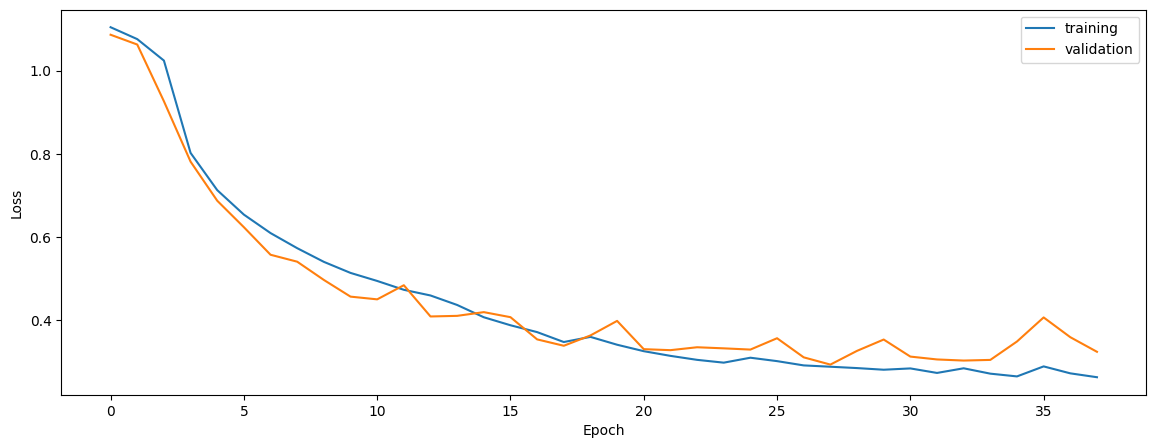

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.8870961685296216


0.8898249691335609


0.8830374088724126


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.9124152281134402


0.9070353469999319


0.8972721193534254


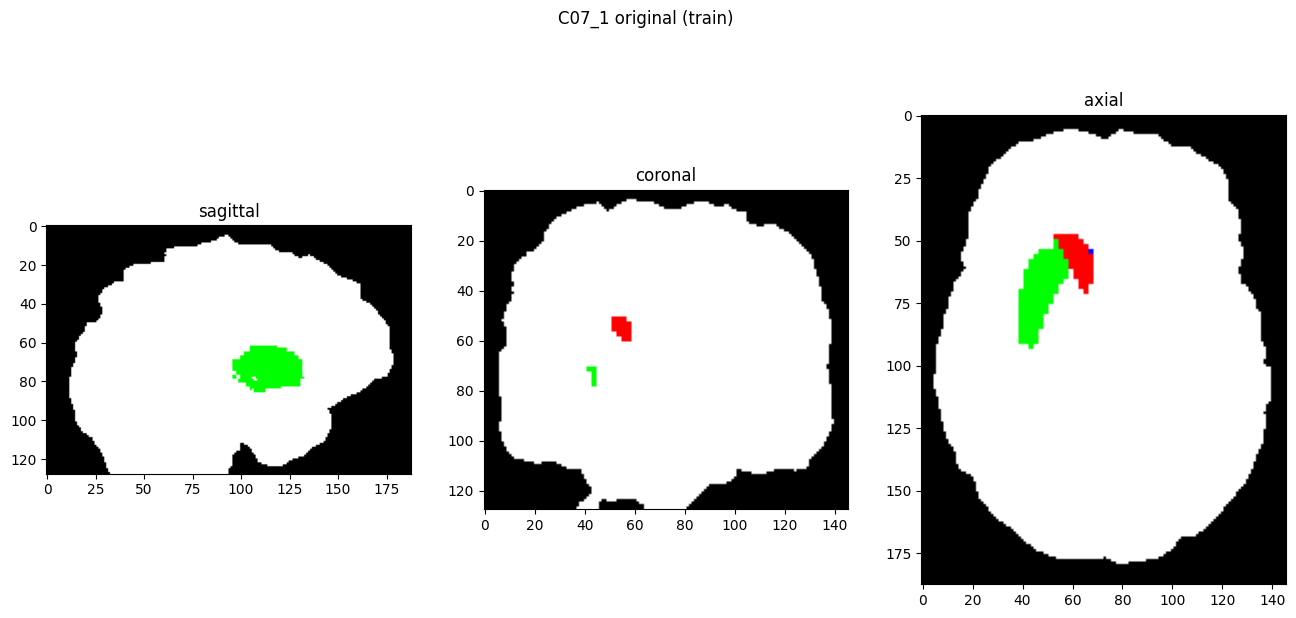

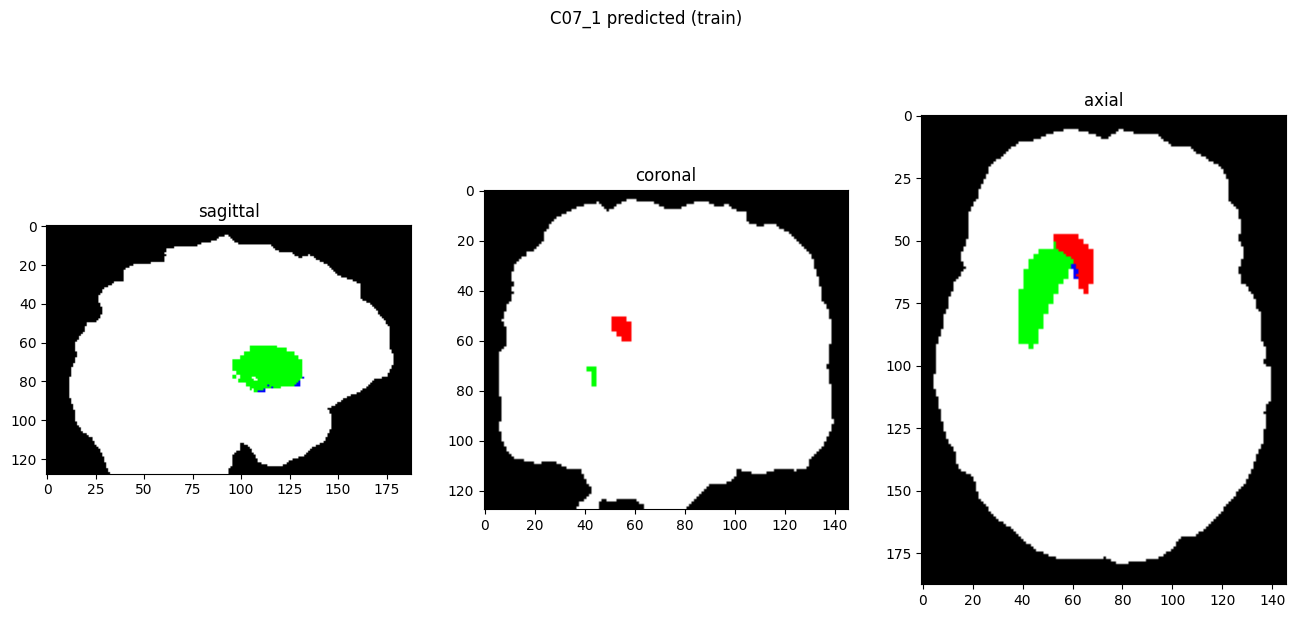

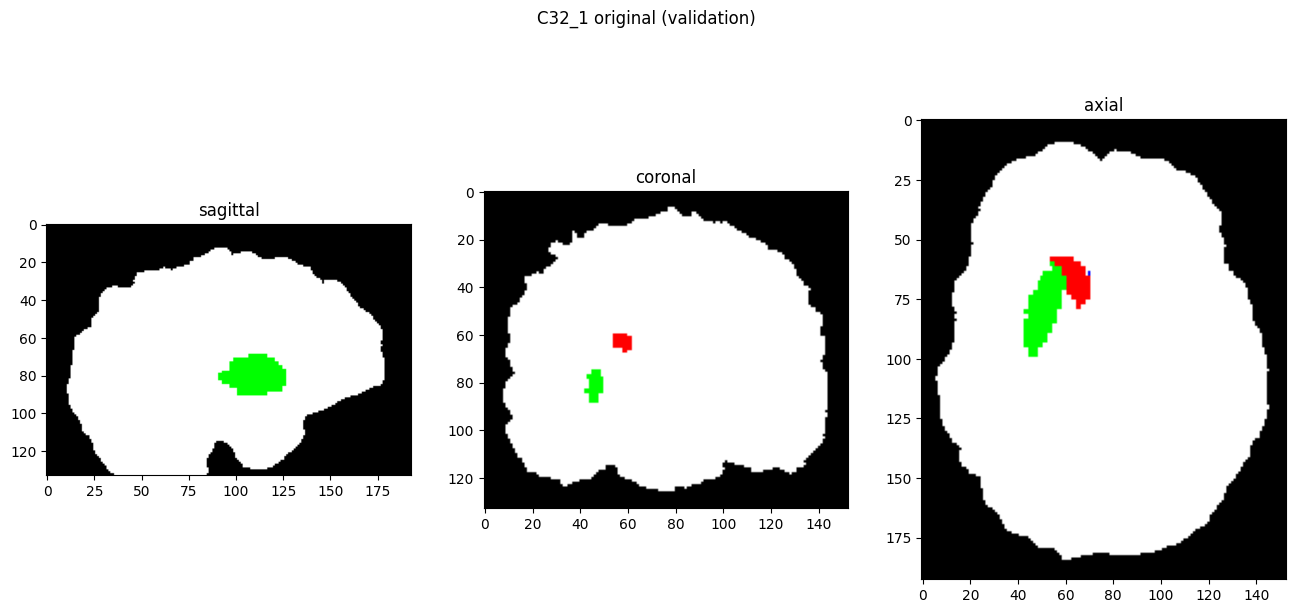

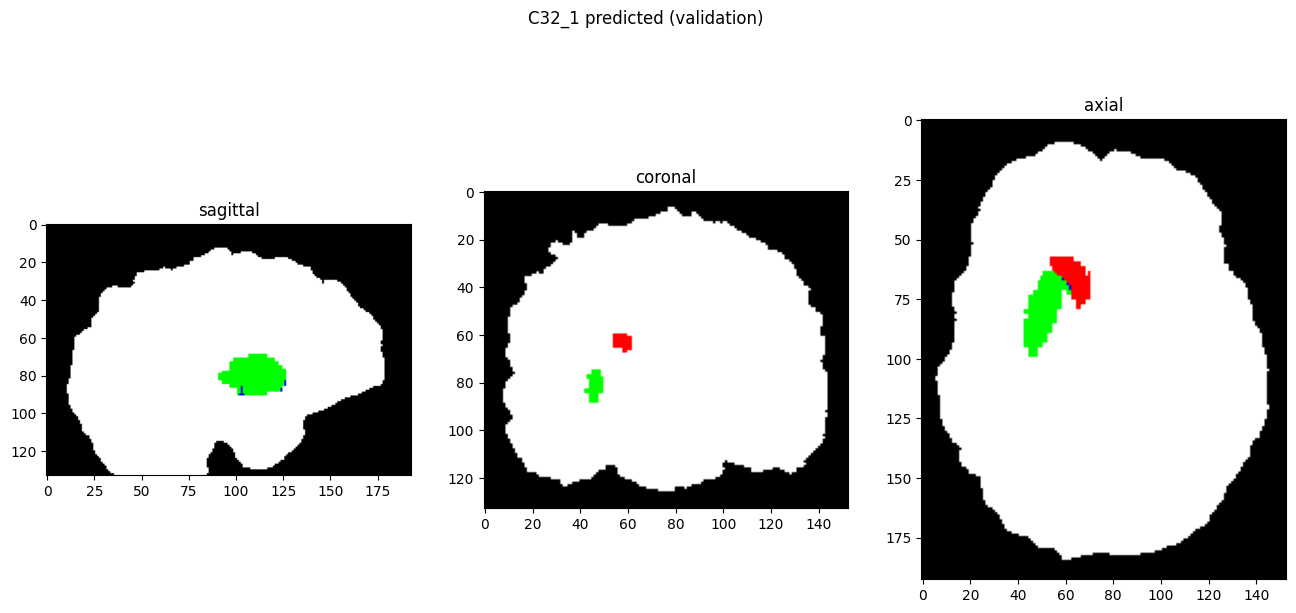

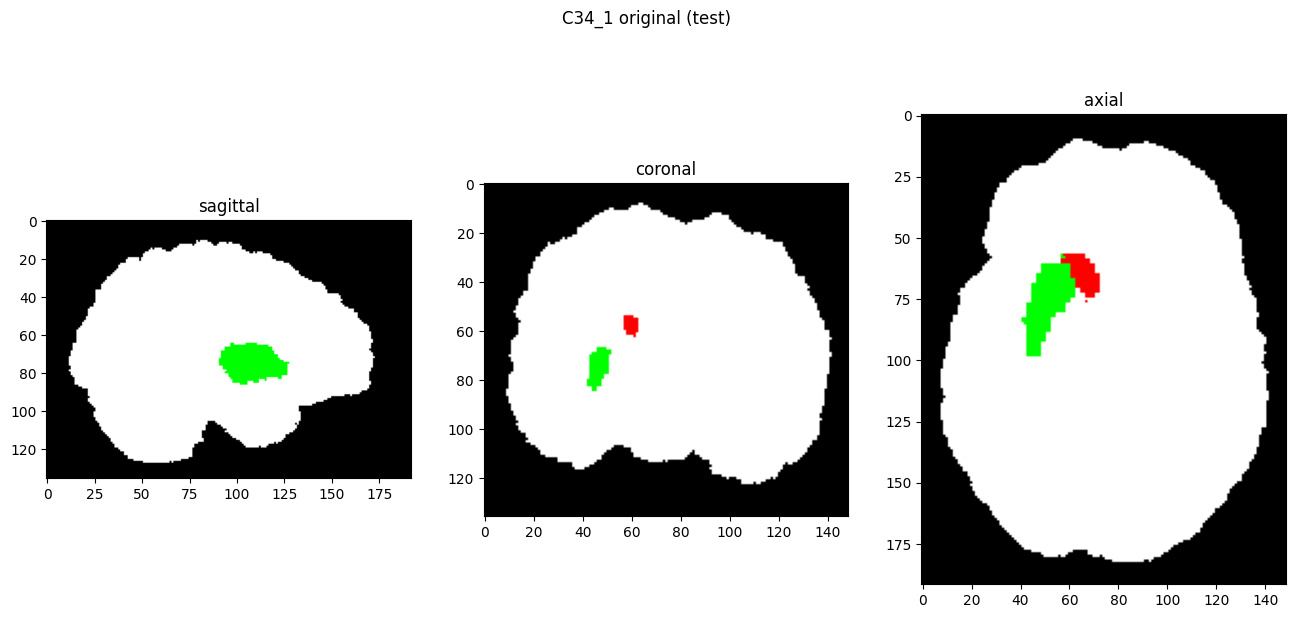

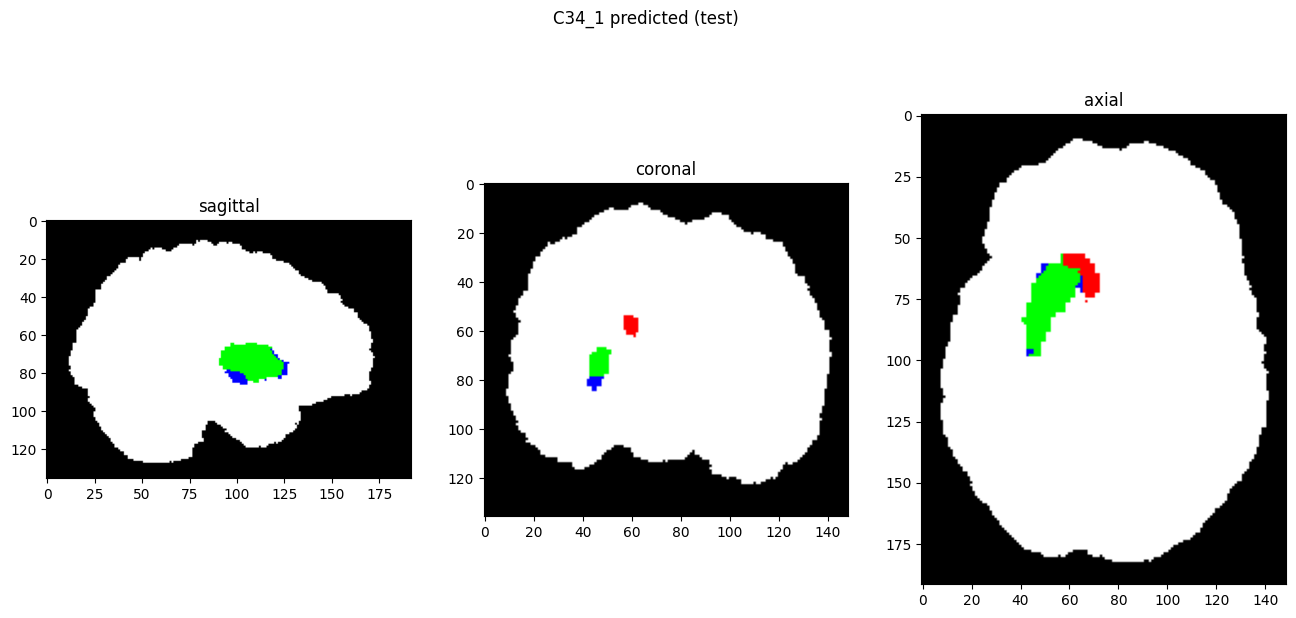

In [9]:
showResults(model, gen, threshold=0)